### Capstone Project 

##### Introduction:

New York city is the most populated city in the United States and is home to one of the world’s largest and fastest growing ethnic demographics. An estimated 9 million people call it home according to 2019 U.S Census data. It’s two key demographic attributes are population density and cultural diversity. Around 36% of the city’s population are born outside of the country. 
Asian Americans are a big part of the immigration population in New York city. New York contains the highest total Asian population of any U.S. city. The Indian American population in the New York City metropolitan region was second in its population as an Asian ethnicity only to the approximately 893,697 Chinese New Yorkers as of 2017. There were 226,888 Indian Americans residing in the city, representing 2.7% of the population.
The graphs below represent Asian American population by ethnicity per Wikipedia 2018 census data and Indian American population by NY city boroughs per Wikipedia 2012-2014 data.
Figures presented below informs that Indian population is quite high and they are mostly concentrated in Queens area. Indian Americans have quite high median income too.

#### Problem:
This Coursera capstone final project will try to identify the best locations for Indian restaurants throughout New York city. Reviewing the Indian population in NY city and recent popularity of Indian food, setting up a new Indian restaurant can be a good and profitable plan. However, as statistics show as opening and running a successful new restaurant demands detail planning, market data analysis and solid financial planning. Accessibility to the location is another huge factor for any long-term business success. In particular, the location of the restaurant is one of the most important factors that will affect whether it will have success or a failure. 
My capstone project will try to answer these two questions for an investor:
1.	What location will be good to open a new Indian restaurant?
2.	Where is the best Indian food available?


Data Needed: We will use New Your city data found at the following link:
https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json.

Data related to Indian restaurants will be obtained via the FourSquare API. Data for ratings, tips and likes submitted by users will be summarized and read to a DataFrame. Folio mapping tool will be used to display the density, location of the existing Indian Restaurants around the NY city boroughs. Data will be grouped, sorted and analyzed to find which location should be new restaurant will be opened and where is the best Indian food available.


## Exploring popularity and density of Indian Restaurants in New York City Neighborhoods

#### Let's import all required libraries before exploring the data .

In [32]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests

#from bs4 import BeautifulSoup
import os

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns

print('Libraries imported.')

Solving environment: ...working... 
  - anaconda/win-64::ca-certificates-2020.10.14-0
  - defaults/win-64::ca-certificates-2020.10.14-0done

# All requested packages already installed.

Libraries imported.


## My variables and credentials for API calls

In [152]:
CLIENT_ID = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx' # your Foursquare ID
CLIENT_SECRET = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'
 # your FourSquare Access Token' # your Foursquare Secret

VERSION = '20180605'
LIMIT = 30
#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

#### Now let's define the functions to be used later in this project

Using geopy library to get the latitude and longitude of the address

In [113]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

#### Define the function to get 100 venues within 500 meters, use the FourSquare API to create the url and send the GET request to get the results in json format

In [114]:
def get_venues(lat,lng):
    #set variables
    radius=500
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df



#### Define the get_venue_details to pull details about the venue, such as likes, ratings, venue names and tips by creating the API url 

In [115]:
def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

#### Get New York data from the link provided below to capture neighborhood details such as Borough, neighborhood names, latitude and longitude

In [116]:
def get_new_york_data():
    url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json'
    #url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data


#### Now let's get our initial NYC data to the codes above

In [119]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [120]:
ny_data.shape

(306, 4)

#### So there are total of 306 different Neighborhoods in New York.

### Initial Data Analysis¶

Now let's analyze our data.

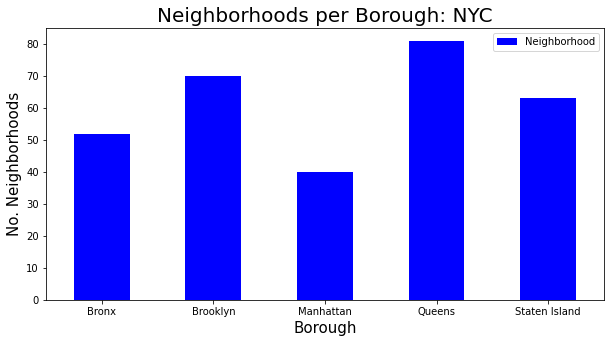

In [121]:

clr = "blue"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

### Find out how many Indian restaurants there are in each neighborhood and borough and graph the results.

In [12]:
# queens has most neighborhoods
# prepare neighborhood list that contains indian restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_restaurants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(ny_data),')','Indian Restaurants in '+Neighborhood+', '+Borough+':'+str(len(indian_restaurants)))
    print(row)
    for resturant_detail in indian_restaurants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Indian Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Indian Restaurants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Indian Restaurants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Indian Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Indian Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Indian Restaurants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Indian Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Indian Restaurants in Woodlawn, Bronx:1
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Indian Restaurants in Norwood, Bronx:0
['Bronx', '

( 68 / 306 ) Indian Restaurants in Red Hook, Brooklyn:0
['Brooklyn', 'Red Hook', 40.676253230250886, -74.0127589747356]
( 69 / 306 ) Indian Restaurants in Gowanus, Brooklyn:1
['Brooklyn', 'Gowanus', 40.673931143187154, -73.99444087145339]
( 70 / 306 ) Indian Restaurants in Fort Greene, Brooklyn:1
['Brooklyn', 'Fort Greene', 40.68852726018977, -73.97290574369092]
( 71 / 306 ) Indian Restaurants in Park Slope, Brooklyn:0
['Brooklyn', 'Park Slope', 40.67232052268197, -73.97705030183924]
( 72 / 306 ) Indian Restaurants in Cypress Hills, Brooklyn:0
['Brooklyn', 'Cypress Hills', 40.68239101144211, -73.87661596457296]
( 73 / 306 ) Indian Restaurants in East New York, Brooklyn:0
['Brooklyn', 'East New York', 40.669925700847045, -73.88069863917366]
( 74 / 306 ) Indian Restaurants in Starrett City, Brooklyn:0
['Brooklyn', 'Starrett City', 40.64758905230874, -73.87936970045875]
( 75 / 306 ) Indian Restaurants in Canarsie, Brooklyn:0
['Brooklyn', 'Canarsie', 40.63556432797428, -73.90209269778966]


( 132 / 306 ) Indian Restaurants in Jackson Heights, Queens:0
['Queens', 'Jackson Heights', 40.75198138007367, -73.88282109164365]
( 133 / 306 ) Indian Restaurants in Elmhurst, Queens:0
['Queens', 'Elmhurst', 40.744048505122024, -73.88165622288388]
( 134 / 306 ) Indian Restaurants in Howard Beach, Queens:0
['Queens', 'Howard Beach', 40.65422527738487, -73.8381376460028]
( 135 / 306 ) Indian Restaurants in Corona, Queens:0
['Queens', 'Corona', 40.74238175015667, -73.85682497345258]
( 136 / 306 ) Indian Restaurants in Forest Hills, Queens:0
['Queens', 'Forest Hills', 40.72526378216503, -73.84447500788983]
( 137 / 306 ) Indian Restaurants in Kew Gardens, Queens:1
['Queens', 'Kew Gardens', 40.7051790354148, -73.82981905825703]
( 138 / 306 ) Indian Restaurants in Richmond Hill, Queens:0
['Queens', 'Richmond Hill', 40.69794731471763, -73.83183321446887]
( 139 / 306 ) Indian Restaurants in Flushing, Queens:0
['Queens', 'Flushing', 40.76445419697846, -73.83177300329582]
( 140 / 306 ) Indian Re

( 199 / 306 ) Indian Restaurants in New Brighton, Staten Island:0
['Staten Island', 'New Brighton', 40.64061455913511, -74.08701650516625]
( 200 / 306 ) Indian Restaurants in Stapleton, Staten Island:0
['Staten Island', 'Stapleton', 40.62692762538176, -74.07790192660066]
( 201 / 306 ) Indian Restaurants in Rosebank, Staten Island:0
['Staten Island', 'Rosebank', 40.61530494652761, -74.06980526716141]
( 202 / 306 ) Indian Restaurants in West Brighton, Staten Island:0
['Staten Island', 'West Brighton', 40.63187892654607, -74.1071817826561]
( 203 / 306 ) Indian Restaurants in Grymes Hill, Staten Island:0
['Staten Island', 'Grymes Hill', 40.624184791313006, -74.08724819983729]
( 204 / 306 ) Indian Restaurants in Todt Hill, Staten Island:0
['Staten Island', 'Todt Hill', 40.59706851814673, -74.1113288180088]
( 205 / 306 ) Indian Restaurants in South Beach, Staten Island:0
['Staten Island', 'South Beach', 40.58024741350956, -74.0795529253982]
( 206 / 306 ) Indian Restaurants in Port Richmond, 

( 260 / 306 ) Indian Restaurants in Remsen Village, Brooklyn:0
['Brooklyn', 'Remsen Village', 40.652117451793494, -73.91665331978048]
( 261 / 306 ) Indian Restaurants in New Lots, Brooklyn:0
['Brooklyn', 'New Lots', 40.6627442796966, -73.88511776379292]
( 262 / 306 ) Indian Restaurants in Paerdegat Basin, Brooklyn:0
['Brooklyn', 'Paerdegat Basin', 40.63131755039667, -73.90233474295836]
( 263 / 306 ) Indian Restaurants in Mill Basin, Brooklyn:0
['Brooklyn', 'Mill Basin', 40.61597423962336, -73.91515391550404]
( 264 / 306 ) Indian Restaurants in Jamaica Hills, Queens:1
['Queens', 'Jamaica Hills', 40.71145964370482, -73.79646462081593]
( 265 / 306 ) Indian Restaurants in Utopia, Queens:0
['Queens', 'Utopia', 40.73350025429757, -73.79671678028349]
( 266 / 306 ) Indian Restaurants in Pomonok, Queens:0
['Queens', 'Pomonok', 40.73493618075478, -73.80486120040537]
( 267 / 306 ) Indian Restaurants in Astoria Heights, Queens:0
['Queens', 'Astoria Heights', 40.7703173929982, -73.89467996270574]
(

In [122]:
indian_rest_ny.to_csv('Indian_rest_ny_tocsv1.csv')

In [123]:
indian_ny = pd.read_csv('Indian_rest_ny_tocsv1.csv')
indian_rest_ny.tail()

,Borough,Neighborhood,ID,Name
32,Manhattan,Civic Center,575dea4c498e2739e43a27e2,Aahar Indian Cuisine
33,Manhattan,Civic Center,50b02338e4b047828b2277c1,Benares
34,Queens,Jamaica Hills,4c434b2bd691c9b6ef8f8f0a,Sagar Restaurant
35,Queens,Jamaica Hills,4c69c4b58e7c0f47d48de00f,Ghoroa Sweets & Restaurant
36,Manhattan,Sutton Place,4fe4fb50c2eee335e4fea69d,Moti Mahal Delux


In [124]:
indian_rest_ny.shape

(37, 4)

In [147]:
#indian_rest_ny.head(37)

In [126]:
indian_rest_ny.groupby('Borough')['ID'].count()

Borough
Bronx             2
Brooklyn         11
Manhattan        15
Queens            8
Staten Island     1
Name: ID, dtype: int64

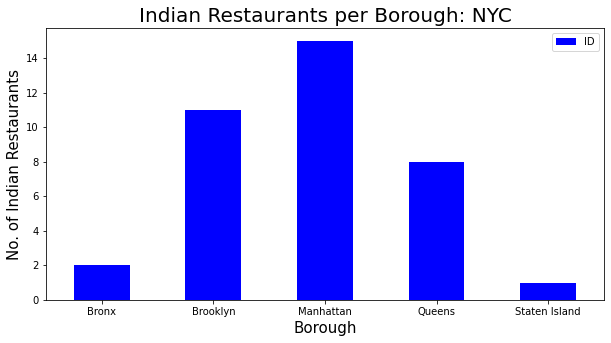

In [127]:
indian_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Indian Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Indian Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

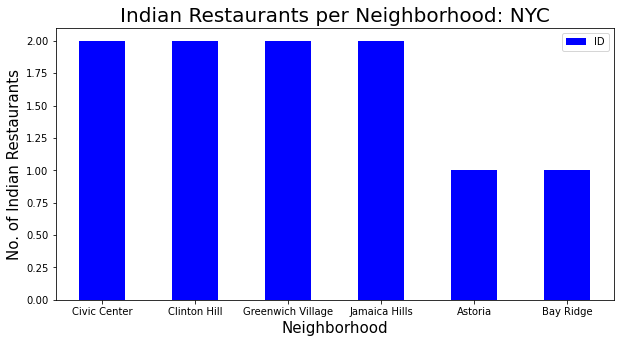

In [128]:
NOofNeigh = 6 # top number for graphing all the same past 6
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Indian Restaurants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No. of Indian Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [129]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Murray Hill']

,Borough,Neighborhood,ID,Name


In [130]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
indian_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '604167be3e5e80487e08c0cc'}, 'response': {'venue': {'id': '4c0448d9310fc9b6bf1dc761', 'name': 'Curry Spot', 'contact': {'phone': '7187085900', 'formattedPhone': '(718) 708-5900'}, 'location': {'address': '4268 Katonah Ave', 'crossStreet': 'E 235 Street', 'lat': 40.897624941880906, 'lng': -73.86714729157393, 'labeledLatLngs': [{'label': 'display', 'lat': 40.897624941880906, 'lng': -73.86714729157393}, {'label': 'entrance', 'lat': 40.897709, 'lng': -73.86707}], 'postalCode': '10470', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4268 Katonah Ave (E 235 Street)', 'Bronx, NY 10470', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/curry-spot/4c0448d9310fc9b6bf1dc761', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 

{'meta': {'code': 200, 'requestId': '604167c7e5a64f343044335c'}, 'response': {'venue': {'id': '545835a1498e820edc6f636f', 'name': 'Bombay Grill', 'contact': {'phone': '7184912500', 'formattedPhone': '(718) 491-2500'}, 'location': {'address': '8716 3rd Ave', 'lat': 40.622371, 'lng': -74.03179899999999, 'labeledLatLngs': [{'label': 'display', 'lat': 40.622371, 'lng': -74.03179899999999}, {'label': 'entrance', 'lat': 40.622344, 'lng': -74.031673}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['8716 3rd Ave', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bombay-grill/545835a1498e820edc6f636f', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 4

{'meta': {'code': 200, 'requestId': '604167d27890fd59af272412'}, 'response': {'venue': {'id': '5169f5c4e4b0c7fcb77a0f3c', 'name': 'Agra Heights', 'contact': {'phone': '7184435700', 'formattedPhone': '(718) 443-5700'}, 'location': {'address': '226 Wilson Ave', 'crossStreet': 'btwn Harman & Himrod St', 'lat': 40.698094445626104, 'lng': -73.92135507234042, 'labeledLatLngs': [{'label': 'display', 'lat': 40.698094445626104, 'lng': -73.92135507234042}, {'label': 'entrance', 'lat': 40.698115, 'lng': -73.921387}], 'postalCode': '11237', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['226 Wilson Ave (btwn Harman & Himrod St)', 'Brooklyn, NY 11237', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/agra-heights/5169f5c4e4b0c7fcb77a0f3c', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/

{'meta': {'code': 200, 'requestId': '604167d52c188b2f805f1de3'}, 'response': {'venue': {'id': '4b8ffc16f964a520246e33e3', 'name': 'Curry Heights', 'contact': {'phone': '7182609000', 'formattedPhone': '(718) 260-9000', 'twitter': 'curryheights'}, 'location': {'address': '151 Remsen St', 'crossStreet': 'btwn Court St & Clinton St', 'lat': 40.69357223828141, 'lng': -73.99226545349896, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69357223828141, 'lng': -73.99226545349896}, {'label': 'entrance', 'lat': 40.693578, 'lng': -73.992235}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['151 Remsen St (btwn Court St & Clinton St)', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/curry-heights/4b8ffc16f964a520246e33e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4

{'meta': {'code': 200, 'requestId': '604167dac81db07f060b723b'}, 'response': {'venue': {'id': '52f18573498ec2c34e830ffd', 'name': "Kanan's Indian Restaurant", 'contact': {'phone': '7183693777', 'formattedPhone': '(718) 369-3777'}, 'location': {'address': '452 3rd Ave', 'crossStreet': '9th Street', 'lat': 40.671890999999995, 'lng': -73.99094000000001, 'labeledLatLngs': [{'label': 'display', 'lat': 40.671890999999995, 'lng': -73.99094000000001}, {'label': 'entrance', 'lat': 40.671842, 'lng': -73.990867}], 'postalCode': '11215', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['452 3rd Ave (9th Street)', 'Brooklyn, NY 11215', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kanans-indian-restaurant/52f18573498ec2c34e830ffd', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_

{'meta': {'code': 200, 'requestId': '604167df6a66e33d37c2d970'}, 'response': {'venue': {'id': '57596dad498e732300496b23', 'name': 'Dosa Royale', 'contact': {'phone': '7185763800', 'formattedPhone': '(718) 576-3800'}, 'location': {'address': '258 Dekalb Ave', 'lat': 40.689466368706604, 'lng': -73.96870434089776, 'labeledLatLngs': [{'label': 'display', 'lat': 40.689466368706604, 'lng': -73.96870434089776}], 'postalCode': '11205', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['258 Dekalb Ave', 'New York, NY 11205', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dosa-royale/57596dad498e732300496b23', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 24}, 'url': 'http://www.dosaroyale.com', 

{'meta': {'code': 200, 'requestId': '604167e6b44df331a33008ca'}, 'response': {'venue': {'id': '568d3902498e619efcbc3f58', 'name': 'Spice & Grill', 'contact': {}, 'location': {'address': '441 Myrtle Ave', 'crossStreet': 'Waverly', 'lat': 40.693389, 'lng': -73.968028, 'labeledLatLngs': [{'label': 'display', 'lat': 40.693389, 'lng': -73.968028}], 'postalCode': '11205', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['441 Myrtle Ave (Waverly)', 'Brooklyn, NY 11205', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/spice--grill/568d3902498e619efcbc3f58', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'count': 21, 'gro

{'meta': {'code': 200, 'requestId': '604167f2884c3a483fc40928'}, 'response': {'venue': {'id': '543870ec498ec64de510608d', 'name': 'Masala Grill', 'contact': {}, 'location': {'address': 'Atlantic Avenue', 'crossStreet': '3rd Avenue', 'lat': 40.68554017378092, 'lng': -73.98120188318653, 'labeledLatLngs': [{'label': 'display', 'lat': 40.68554017378092, 'lng': -73.98120188318653}], 'postalCode': '11217', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['Atlantic Avenue (3rd Avenue)', 'Brooklyn, NY 11217', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/masala-grill/543870ec498ec64de510608d', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 14}, 'url': 'http://masalagrillbk.com', 'price': {'tie

{'meta': {'code': 200, 'requestId': '604167f68675981deb7a5665'}, 'response': {'venue': {'id': '4bb93b70cf2fc9b6fe64a002', 'name': 'Gandhi Fine Indian Cuisine', 'contact': {'phone': '7182827012', 'formattedPhone': '(718) 282-7012'}, 'location': {'address': '2032 Bedford Ave', 'crossStreet': 'btwn Clarkson Ave & Parkside Ave', 'lat': 40.65516762218564, 'lng': -73.95632450081226, 'labeledLatLngs': [{'label': 'display', 'lat': 40.65516762218564, 'lng': -73.95632450081226}], 'postalCode': '11226', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2032 Bedford Ave (btwn Clarkson Ave & Parkside Ave)', 'Brooklyn, NY 11226', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/gandhi-fine-indian-cuisine/4bb93b70cf2fc9b6fe64a002', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 's

{'meta': {'code': 200, 'requestId': '604167fc1734f052ccd59e39'}, 'response': {'venue': {'id': '5631511b498e3d6d7e0a4df0', 'name': 'Tikka Indian Grill', 'contact': {'phone': '7187682262', 'formattedPhone': '(718) 768-2262'}, 'location': {'address': '185 Grand Street', 'lat': 40.71434305888687, 'lng': -73.96090327883888, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71434305888687, 'lng': -73.96090327883888}, {'label': 'entrance', 'lat': 40.714397, 'lng': -73.960787}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['185 Grand Street', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tikka-indian-grill/5631511b498e3d6d7e0a4df0', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verif

{'meta': {'code': 200, 'requestId': '60416801c4d8ab10132a87ca'}, 'response': {'venue': {'id': '4ae7876ef964a5201eac21e3', 'name': 'Kismat Indian Restaurant', 'contact': {'phone': '2127958633', 'formattedPhone': '(212) 795-8633', 'twitter': 'kismatindian'}, 'location': {'address': '603 Fort Washington Ave', 'crossStreet': '187th St', 'lat': 40.855221723964846, 'lng': -73.93696683600031, 'labeledLatLngs': [{'label': 'display', 'lat': 40.855221723964846, 'lng': -73.93696683600031}], 'postalCode': '10040', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['603 Fort Washington Ave (187th St)', 'New York, NY 10040', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kismat-indian-restaurant/4ae7876ef964a5201eac21e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '

{'meta': {'code': 200, 'requestId': '604168065e57225b3b39a841'}, 'response': {'venue': {'id': '54c2bd96498eaf5142e3fe92', 'name': 'Clove Indian Restaurant & Bar', 'contact': {'phone': '6469186644', 'formattedPhone': '(646) 918-6644', 'twitter': 'cloveindian'}, 'location': {'address': '1592 Amsterdam Ave', 'crossStreet': 'btwn 139th St & 138th St', 'lat': 40.82128, 'lng': -73.95062, 'labeledLatLngs': [{'label': 'display', 'lat': 40.82128, 'lng': -73.95062}, {'label': 'entrance', 'lat': 40.821289, 'lng': -73.950696}], 'postalCode': '10031', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1592 Amsterdam Ave (btwn 139th St & 138th St)', 'New York, NY 10031', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/clove-indian-restaurant--bar/54c2bd96498eaf5142e3fe92', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4

{'meta': {'code': 200, 'requestId': '6041680b6231b0194888a4b4'}, 'response': {'venue': {'id': '529d382a11d2dd5ef107e641', 'name': 'Chapati House - NYC', 'contact': {'phone': '2127497200', 'formattedPhone': '(212) 749-7200', 'twitter': 'chapatihousenyc'}, 'location': {'address': '3153 Broadway', 'crossStreet': 'Tiemann Pl.', 'lat': 40.81457249971737, 'lng': -73.95915381671377, 'labeledLatLngs': [{'label': 'display', 'lat': 40.81457249971737, 'lng': -73.95915381671377}], 'postalCode': '10027', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3153 Broadway (Tiemann Pl.)', 'New York, NY 10027', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/chapati-house--nyc/529d382a11d2dd5ef107e641', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}

{'meta': {'code': 200, 'requestId': '60416812c7049414421eb347'}, 'response': {'venue': {'id': '4b0dec08f964a520ae5223e3', 'name': 'Alachi Masala', 'contact': {'phone': '2128747420', 'formattedPhone': '(212) 874-7420', 'twitter': 'alachimasala', 'facebook': '833664873419022', 'facebookName': 'Poona Indian Restaurant'}, 'location': {'address': '488 Amsterdam Ave Frnt 1', 'lat': 40.7861663, 'lng': -73.9764143, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7861663, 'lng': -73.9764143}, {'label': 'entrance', 'lat': 40.78615, 'lng': -73.976343}], 'postalCode': '10024', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['488 Amsterdam Ave Frnt 1', 'New York, NY 10024', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/alachi-masala/4b0dec08f964a520ae5223e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net

{'meta': {'code': 200, 'requestId': '6041681a58a5ba5708917d26'}, 'response': {'venue': {'id': '49d91c12f964a520015e1fe3', 'name': 'The Kati Roll Company', 'contact': {'phone': '2127304280', 'formattedPhone': '(212) 730-4280', 'twitter': 'katirollcompany'}, 'location': {'address': '49 W 39th St', 'crossStreet': 'btwn 5th & 6th Ave', 'lat': 40.75265571457166, 'lng': -73.98477837472183, 'labeledLatLngs': [{'label': 'display', 'lat': 40.75265571457166, 'lng': -73.98477837472183}], 'postalCode': '10018', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['49 W 39th St (btwn 5th & 6th Ave)', 'New York, NY 10018', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/the-kati-roll-company/49d91c12f964a520015e1fe3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'},

{'meta': {'code': 200, 'requestId': '6041681f8b43345f454abfe1'}, 'response': {'venue': {'id': '4b4aab62f964a520978c26e3', 'name': 'Dil-e Punjab Deli', 'contact': {'phone': '2126479428', 'formattedPhone': '(212) 647-9428', 'twitter': 'dilepunjabdeli'}, 'location': {'address': '170 9th Ave', 'crossStreet': 'at 21st St', 'lat': 40.74484451009235, 'lng': -74.00252750283143, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74484451009235, 'lng': -74.00252750283143}, {'label': 'entrance', 'lat': 40.744917, 'lng': -74.002266}], 'postalCode': '10011', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['170 9th Ave (at 21st St)', 'New York, NY 10011', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dile-punjab-deli/4b4aab62f964a520978c26e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/f

{'meta': {'code': 200, 'requestId': '604168269d6ba16ecd843198'}, 'response': {'venue': {'id': '56c931b2cd10407d3ecbefda', 'name': 'Ananda', 'contact': {}, 'location': {'address': '210 Thompson St', 'crossStreet': 'btwn W 3rd & Bleecker Sts', 'lat': 40.72883889496238, 'lng': -73.9993364782382, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72883889496238, 'lng': -73.9993364782382}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['210 Thompson St (btwn W 3rd & Bleecker Sts)', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ananda/56c931b2cd10407d3ecbefda', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 20}, 'url': 'http://www.ahimsa.nyc', '

{'meta': {'code': 200, 'requestId': '6041682b0027e6019f80d355'}, 'response': {'venue': {'id': '4d992c1e942ba093ebb5968c', 'name': 'THELEwala', 'contact': {'phone': '2126149100', 'formattedPhone': '(212) 614-9100'}, 'location': {'address': '112 Macdougal St', 'crossStreet': 'at Minetta St.', 'lat': 40.72972369809264, 'lng': -74.00073006181881, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72972369809264, 'lng': -74.00073006181881}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['112 Macdougal St (at Minetta St.)', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/thelewala/4d992c1e942ba093ebb5968c', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1cb941735', 

{'meta': {'code': 200, 'requestId': '6041683050681545b486f4bc'}, 'response': {'venue': {'id': '4bbb9dbded7776b0e1ad3e51', 'name': 'Tamarind TriBeCa', 'contact': {'phone': '2127759000', 'formattedPhone': '(212) 775-9000', 'facebook': '201503306550753', 'facebookName': 'Tamarind Tribeca'}, 'location': {'address': '99 Hudson St', 'crossStreet': 'at Franklin St', 'lat': 40.71921117375622, 'lng': -74.00872657957527, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71921117375622, 'lng': -74.00872657957527}, {'label': 'entrance', 'lat': 40.719084, 'lng': -74.008899}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['99 Hudson St (at Franklin St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tamarind-tribeca/4bbb9dbded7776b0e1ad3e51', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'pre

{'meta': {'code': 200, 'requestId': '6041683416719e5ca5787502'}, 'response': {'venue': {'id': '5803c0db38fa71491b748a7d', 'name': 'Taco Mahal', 'contact': {'phone': '6467191553', 'formattedPhone': '(646) 719-1553', 'instagram': 'tacomahalnyc', 'facebook': '575545749278543', 'facebookUsername': 'TacoMahalnyc', 'facebookName': 'Taco Mahal'}, 'location': {'address': '73 7th Ave S', 'lat': 40.73240508476288, 'lng': -74.00350113625272, 'labeledLatLngs': [{'label': 'display', 'lat': 40.73240508476288, 'lng': -74.00350113625272}], 'postalCode': '10014', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['73 7th Ave S', 'New York, NY 10014', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/taco-mahal/5803c0db38fa71491b748a7d', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 's

{'meta': {'code': 200, 'requestId': '60416839690fe037853399c7'}, 'response': {'venue': {'id': '4d24b812836f5481518645f7', 'name': 'Doaba Deli', 'contact': {'phone': '2122222636', 'formattedPhone': '(212) 222-2636'}, 'location': {'address': '945 Columbus Ave', 'crossStreet': 'btw W 106th & 107th', 'lat': 40.799513471286254, 'lng': -73.96266286944638, 'labeledLatLngs': [{'label': 'display', 'lat': 40.799513471286254, 'lng': -73.96266286944638}], 'postalCode': '10025', 'cc': 'US', 'neighborhood': 'Upper West Side', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['945 Columbus Ave (btw W 106th & 107th)', 'New York, NY 10025', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/doaba-deli/4d24b812836f5481518645f7', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'pri

{'meta': {'code': 200, 'requestId': '6041683dc7049414421f19dc'}, 'response': {'venue': {'id': '5d8d9c5e0a2ffc0008f28855', 'name': 'The Gully', 'contact': {'phone': '7188873933', 'formattedPhone': '(718) 887-3933'}, 'location': {'address': '2545 Steinway St', 'lat': 40.766719, 'lng': -73.91241, 'labeledLatLngs': [{'label': 'display', 'lat': 40.766719, 'lng': -73.91241}], 'postalCode': '11103', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2545 Steinway St', 'New York, NY 11103', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/the-gully/5d8d9c5e0a2ffc0008f28855', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 4}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'

{'meta': {'code': 200, 'requestId': '604168429d6ba16ecd8473b8'}, 'response': {'venue': {'id': '5782c9ce498edde587f5aa14', 'name': 'Tikka Indian Grill', 'contact': {'phone': '7184801307', 'formattedPhone': '(718) 480-1307'}, 'location': {'address': '119-30 Metropolitan Ave', 'lat': 40.70587364181698, 'lng': -73.83094233462995, 'labeledLatLngs': [{'label': 'display', 'lat': 40.70587364181698, 'lng': -73.83094233462995}], 'postalCode': '11415', 'cc': 'US', 'city': 'Queens', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['119-30 Metropolitan Ave', 'Queens, NY 11415', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tikka-indian-grill/5782c9ce498edde587f5aa14', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 2}, 'url': 'http

{'meta': {'code': 200, 'requestId': '6041684e8b43345f454b2d8e'}, 'response': {'venue': {'id': '58855a59af7d1717fffdf996', 'name': 'Fresh Pond Spice', 'contact': {'phone': '7184175100', 'formattedPhone': '(718) 417-5100'}, 'location': {'address': '6402 Fresh Pond Rd', 'lat': 40.71014, 'lng': -73.899582, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71014, 'lng': -73.899582}], 'postalCode': '11385', 'cc': 'US', 'city': 'Queens', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['6402 Fresh Pond Rd', 'Queens, NY 11385', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/fresh-pond-spice/58855a59af7d1717fffdf996', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'

{'meta': {'code': 200, 'requestId': '6041685d2c018a7a21b866cf'}, 'response': {'venue': {'id': '4be74a502468c928505a0243', 'name': 'Taste Of India II', 'contact': {'phone': '7189874700', 'formattedPhone': '(718) 987-4700'}, 'location': {'address': '287 New Dorp Ln', 'lat': 40.57212651619049, 'lng': -74.11267401240129, 'labeledLatLngs': [{'label': 'display', 'lat': 40.57212651619049, 'lng': -74.11267401240129}], 'postalCode': '10306', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['287 New Dorp Ln', 'Staten Island, NY 10306', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/taste-of-india-ii/4be74a502468c928505a0243', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d142941735', 'name': 'Asian Restaurant'

{'meta': {'code': 200, 'requestId': '6041686216719e5ca578e03d'}, 'response': {'venue': {'id': '5a1e961c1987ec47beed877d', 'name': 'Baar Baar', 'contact': {'phone': '2122281200', 'formattedPhone': '(212) 228-1200', 'twitter': 'baarbaarnyc', 'instagram': 'baarbaarnyc', 'facebook': '478023699251632', 'facebookUsername': 'baarbaarnyc', 'facebookName': 'Baar Baar'}, 'location': {'address': '13 E 1st St', 'crossStreet': 'btw Bowery & 2nd Ave', 'lat': 40.724533801523286, 'lng': -73.99162419418478, 'labeledLatLngs': [{'label': 'display', 'lat': 40.724533801523286, 'lng': -73.99162419418478}], 'postalCode': '10003', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['13 E 1st St (btw Bowery & 2nd Ave)', 'New York, NY 10003', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/baar-baar/5a1e961c1987ec47beed877d', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'In

{'meta': {'code': 200, 'requestId': '60416867b6c38859d0d3481d'}, 'response': {'venue': {'id': '575dea4c498e2739e43a27e2', 'name': 'Aahar Indian Cuisine', 'contact': {'phone': '6466493374', 'formattedPhone': '(646) 649-3374'}, 'location': {'address': '10 Murray St', 'crossStreet': 'Broadway', 'lat': 40.71330656515891, 'lng': -74.00799405698501, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71330656515891, 'lng': -74.00799405698501}], 'postalCode': '10007', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['10 Murray St (Broadway)', 'New York, NY 10007', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/aahar-indian-cuisine/575dea4c498e2739e43a27e2', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'ti

{'meta': {'code': 200, 'requestId': '6041686be44ab668c73624a8'}, 'response': {'venue': {'id': '50b02338e4b047828b2277c1', 'name': 'Benares', 'contact': {'phone': '2129670400', 'formattedPhone': '(212) 967-0400'}, 'location': {'address': '45 Murray St', 'crossStreet': 'Park Place', 'lat': 40.714117, 'lng': -74.009248, 'labeledLatLngs': [{'label': 'display', 'lat': 40.714117, 'lng': -74.009248}], 'postalCode': '10007', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['45 Murray St (Park Place)', 'New York, NY 10007', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/benares/50b02338e4b047828b2277c1', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 44}, 'url': 'http://www.benaresnyc.com', 'pri

{'meta': {'code': 200, 'requestId': '6041686fe44ab668c7362e45'}, 'response': {'venue': {'id': '4c434b2bd691c9b6ef8f8f0a', 'name': 'Sagar Restaurant', 'contact': {'phone': '7182985696', 'formattedPhone': '(718) 298-5696'}, 'location': {'address': '168-25 B Hillside Ave', 'lat': 40.710328623498505, 'lng': -73.79412262466633, 'labeledLatLngs': [{'label': 'display', 'lat': 40.710328623498505, 'lng': -73.79412262466633}], 'postalCode': '11432', 'cc': 'US', 'city': 'Jamaica', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['168-25 B Hillside Ave', 'Jamaica, NY 11432', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sagar-restaurant/4c434b2bd691c9b6ef8f8f0a', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'url': 'http://

{'meta': {'code': 200, 'requestId': '60416874aab20d188bc4c0a6'}, 'response': {'venue': {'id': '4c69c4b58e7c0f47d48de00f', 'name': 'Ghoroa Sweets & Restaurant', 'contact': {'phone': '7186571000', 'formattedPhone': '(718) 657-1000'}, 'location': {'address': '168-41 Hillside Ave', 'lat': 40.71076627368326, 'lng': -73.79340678825332, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71076627368326, 'lng': -73.79340678825332}], 'postalCode': '11432', 'cc': 'US', 'city': 'Jamaica', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['168-41 Hillside Ave', 'Jamaica, NY 11432', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ghoroa-sweets--restaurant/4c69c4b58e7c0f47d48de00f', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 4}, 'p

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
32,Manhattan,Civic Center,575dea4c498e2739e43a27e2,Aahar Indian Cuisine,53,8.3,20
33,Manhattan,Civic Center,50b02338e4b047828b2277c1,Benares,97,7.5,44
34,Queens,Jamaica Hills,4c434b2bd691c9b6ef8f8f0a,Sagar Restaurant,10,7.2,6
35,Queens,Jamaica Hills,0,0,0,0.0,0
36,Manhattan,Sutton Place,4fe4fb50c2eee335e4fea69d,Moti Mahal Delux,186,8.4,83


In [149]:
#indian_rest_stats_ny.head(37)

In [132]:

indian_rest_stats_ny.to_csv('indian_rest_stats_ny_csv.csv') # save data to a .csv file

In [133]:
indian_rest_stats_ny.shape

(37, 7)

We got statistics for all 37 Indian Restaurants in New York city.

Let's verify what data types we have in our DataFrame

In [135]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       37 non-null     object 
 1   Neighborhood  37 non-null     object 
 2   ID            37 non-null     object 
 3   Name          37 non-null     object 
 4   Likes         37 non-null     object 
 5   Rating        37 non-null     float64
 6   Tips          37 non-null     object 
dtypes: float64(1), object(6)
memory usage: 2.1+ KB


We see that the values like Likes, Tips are string values. We have to convert them into float for further analysis

In [136]:
indian_rest_stats_ny['Likes'] = indian_rest_stats_ny['Likes'].astype('float64')
indian_rest_stats_ny['Tips'] = indian_rest_stats_ny['Tips'].astype('float64')
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       37 non-null     object 
 1   Neighborhood  37 non-null     object 
 2   ID            37 non-null     object 
 3   Name          37 non-null     object 
 4   Likes         37 non-null     float64
 5   Rating        37 non-null     float64
 6   Tips          37 non-null     float64
dtypes: float64(3), object(4)
memory usage: 2.1+ KB


#### After the data types look correct, let's do further analysis

In [137]:
indian_rest_stats_ny.describe()

,Likes,Rating,Tips
count,37.000000,37.000000,37.000000
mean,88.756757,7.337838,31.243243
std,164.718009,1.980089,49.415138
min,0.000000,0.000000,0.000000
25%,12.000000,7.400000,6.000000
50%,35.000000,7.800000,17.000000
75%,83.000000,8.400000,28.000000
max,834.000000,9.100000,256.000000


In [150]:
#Borough, neighborhood and restaurant with maximum likes
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                834
Rating                               8.6
Tips                                 256
Name: 17, dtype: object

In [139]:
# Resturant with maximum Ratings
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                601
Rating                               9.1
Tips                                 151
Name: 21, dtype: object

In [140]:
# Resturant with maximum Tips
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                834
Rating                               8.6
Tips                                 256
Name: 17, dtype: object

#### Let's find out the neighborhood with highest average rating for restaurants

In [156]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
27,Tribeca,9.10
6,Chelsea,8.80
21,Noho,8.70
23,Prospect Lefferts Gardens,8.70
12,Greenwich Village,8.65
19,Midtown,8.60
9,Fort Greene,8.50
31,West Village,8.50
26,Sutton Place,8.40
22,North Side,8.20



Above are the top neighborhoods with the highest average ratings of Indian restaurants.

In [154]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.266667
4,Staten Island,8.200000
1,Brooklyn,7.400000
0,Bronx,6.750000
3,Queens,5.550000


Similarly these are the average ratings of Indian Restaurants for each Borough

#### Let's graph the results

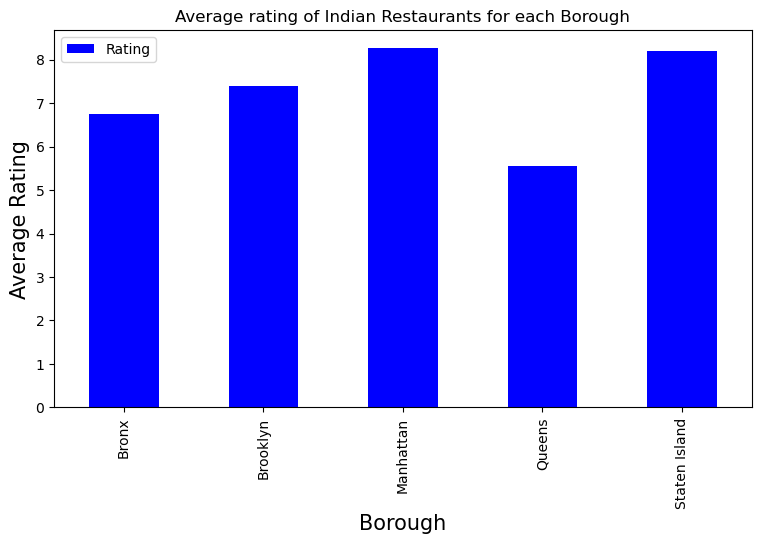

In [143]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Indian Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color=clr)
plt.legend()
plt.show()

We will consider all the neighborhoods with average rating greater or equal 8.0 to visualize on a map

In [157]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
2,Bayside,8.20
3,Boerum Hill,8.10
6,Chelsea,8.80
9,Fort Greene,8.50
12,Greenwich Village,8.65
19,Midtown,8.60
20,New Dorp,8.20
21,Noho,8.70
22,North Side,8.20
23,Prospect Lefferts Gardens,8.70


We will join this Dataset to original New York data to get longitude and latitude

In [145]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Bayside,40.766041,-73.774274,8.20
1,Brooklyn,Boerum Hill,40.685683,-73.983748,8.10
2,Manhattan,Chelsea,40.744035,-74.003116,8.80
3,Staten Island,Chelsea,40.594726,-74.189560,8.80
4,Brooklyn,Fort Greene,40.688527,-73.972906,8.50
5,Manhattan,Greenwich Village,40.726933,-73.999914,8.65
6,Manhattan,Midtown,40.754691,-73.981669,8.60
7,Staten Island,New Dorp,40.572572,-74.116479,8.20
8,Manhattan,Noho,40.723259,-73.988434,8.70
9,Brooklyn,North Side,40.714823,-73.958809,8.20


Now we will show this data on a map

In [146]:

# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [39]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)